# This file compares and analyses the IMBI_Marko miner

In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'C:/Users/Marko/Desktop/GIt/IMBI_Master')

In [2]:
from local_pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.log.importer.xes import importer as xes_importer
from local_pm4py.algo.analysis import custom_enum
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py import view_petri_net
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py import precision_alignments
from pm4py import precision_token_based_replay
from pm4py import discover_petri_net_heuristics
from pm4py.convert import convert_to_petri_net
from pm4py.algo.discovery.inductive import algorithm as pm4py_algorithm
from pm4py.algo.discovery.inductive.variants import imf as pm4py_imf
import pandas as pd
from pm4py.algo.discovery.inductive.algorithm import Variants as ind_Variants
from local_pm4py.algo.analysis import Optimzation_Goals
import matplotlib.pyplot as plt
import numpy as np
import math
import fpdf
from PIL import Image
import os

In [3]:
def f1_score(a, b):
  # try: catch
  if math.isclose(a+b,0):
    return 0
  return 2 * (a * b) / (a + b)

In [4]:
def visualize_cuts(fileName):
  pdf = fpdf.FPDF(format='letter') #pdf format
  pdf.add_page() #create new page
  pdf.set_font("Arial", size=8) # font and textsize

  depth = 0
  currentIteration = 1
  file_path = "imbi_cuts/depth_" + str(depth) + "_It_" + str(currentIteration)
  # for depth
  while(os.path.isfile(file_path + ".png")):
    # for iteration
    while(os.path.isfile(file_path + ".png")):
      with open(file_path + ".txt") as f:
        pdf.cell(100, 4, txt="Cut: " + str(depth + 1) + " it: " + str(currentIteration), ln=1, align="C")
        pdf.cell(1000, 4, txt="cut | type | cost_p | cost_m | cost_ratio | fitP", ln=1, align="L")
        pdf.cell(1000, 4, txt="", ln=1, align="L")
        lines = f.readlines()
        readLines = 0
        for line in lines:
          if readLines == 0:
            outputLine = line.replace(" ", " | ")
          else:
            outputLine = line
          pdf.cell(1000, 4, txt=outputLine, ln=1, align="L")
          readLines += 1
          if readLines == 3:
            readLines = 0
            pdf.cell(1000, 4, txt="", ln=1, align="L")
      img = Image.open(file_path + ".png")
      width,height = img.size
      # print(width, height)
      pdf.image(file_path + ".png",w=min(150,width/3),h=min(150,height/3))
      pdf.add_page()
      currentIteration += 1
      file_path = "imbi_cuts/depth_" + str(depth) + "_It_" + str(currentIteration)
      
    depth += 1
    currentIteration = 1
    file_path = "imbi_cuts/depth_" + str(depth) + "_It_" + str(currentIteration)
  pdf.output(fileName + ".pdf")

In [5]:
def visualize_petriNet(df, miner, logPName, logMName = ""):
  df_temp = df[df["miner"] == miner]
  df_temp = df_temp[df_temp["logM_Name"] == logMName]
  df_temp = df_temp[df_temp["logP_Name"] == logPName]
  for net, im, fm in zip(df_temp.net, df_temp.im, df_temp.fm):
    print("Displaying: " + str(miner) + " " + str(logPName) + " " + str(logMName))
    view_petri_net(net, im, fm)

In [6]:
def visualize_All_petriNet(df, miner):
  df_temp = df[df["miner"] == miner]
  for logPName, logMName in zip(df_temp.logP_Name, df_temp.logM_Name):
    visualize_petriNet(df,miner,logPName,logMName)

In [7]:
def runDoubleLogEvaluation(df,log,logM, name,net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0):
  mes = Optimzation_Goals.apply_petri(log,logM,net,im,fm)

  df = pd.concat([df, pd.DataFrame.from_records([{
    "miner" : name,
    "logP_Name": logPName[:logPName.rfind(".")],
    "logM_Name": logMName[:logMName.rfind(".")],
    "imf_noise_thr" : imf_noiseThreshold,
    "hm_depen_thr" : hm_dependency_threshold,
    "im_bi_sup" : im_bi_sup,
    "im_bi_ratio" : im_bi_ratio,
    "acc_logs": mes['acc'],
    "fitP" : mes['fitP'],
    "fitM" : mes['fitM'],
    "f1_fit_logs": mes['F1'],
    "precP" : mes['precision'],
    "net": net,
    "im" : im,
    "fm" : fm
  }])])
  return df

In [8]:
def runSingleLogEvaluation(df,log,logM, name,net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0):
  parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT:"pdf"}
  gviz = pn_visualizer.apply(net, im, fm, parameters=parameters)

  try:
    fitness_token = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)["log_fitness"]
  except:
    fitness_token = 0
  try:
    fitness_align = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)["log_fitness"]
  except:
    fitness_align = 0
    
  try:
    prec_token = precision_token_based_replay(log, net, im, fm)
  except:
    prec_token = 0
    
  try:
    prec_alignment = precision_alignments(log, net, im, fm)
  except:
    prec_alignment = 0

  df = pd.concat([df, pd.DataFrame.from_records([{
      "miner" : name,
      "logP_Name": logPName,
      "logM_Name": logMName,
      "imf_noise_thr" : imf_noiseThreshold,
      "hm_depen_thr" : hm_dependency_threshold,
      "im_bi_sup" : im_bi_sup,
      "im_bi_ratio" : im_bi_ratio,
      "fit_tok": fitness_token,
      "fit_alig": fitness_align,
      "prec_tok": prec_token,
      "prec_alig": prec_alignment,
      "f1_tok": f1_score(fitness_token, prec_token),
      "f1_alig": f1_score(fitness_align, prec_alignment),
      "net": net,
      "im" : im,
      "fm" : fm
  }])])
  return df

In [9]:
def add_Model_To_Database(df,log,logM, name,net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0):
  if logMName == "":
    df = runSingleLogEvaluation(df,log,logM, name,net, im, fm, logPName,logMName, imf_noiseThreshold, hm_dependency_threshold,im_bi_sup, im_bi_ratio)
  else:
    df = runDoubleLogEvaluation(df,log,logM, name,net, im, fm, logPName,logMName, imf_noiseThreshold, hm_dependency_threshold,im_bi_sup, im_bi_ratio)
  return df

In [10]:
def getF1Value(df, miner, logPName, logMName, support, ratio):
  dftemp = df[df["miner"] == miner]
  dftemp = dftemp[dftemp["logP_Name"] == logPName[:logPName.rfind(".")]]
  dftemp = dftemp[dftemp["logM_Name"] == logMName[:logPName.rfind(".")]]
  dftemp = dftemp[dftemp["im_bi_sup"] == support]
  dftemp = dftemp[dftemp["im_bi_ratio"] == ratio]
  if len(dftemp.index) > 1:
    raise Exception("Error, too many rows.")
  return dftemp["f1_fit_logs"].iloc[0]


In [11]:
def applyMinerToLog(df, logPathP, logPathM,logPName, logMName = "", noiseThreshold = 0.0, dependency_threshold=0.0, support = 0, ratio = 0):
  logP = xes_importer.apply(logPathP)
  if logMName == "":
    logM = logP
    # inductive miner
    print("Running IM")
    pt = pm4py_algorithm.apply(logP,variant=ind_Variants.IM)
    net, im, fm = convert_to_petri_net(pt)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IM",logPName=logPName)
    
    #imf 
    print("Running IMF")
    parameters = {pm4py_imf.IMFParameters.NOISE_THRESHOLD : noiseThreshold}
    pt = pm4py_algorithm.apply(logP,variant=ind_Variants.IMf, parameters=parameters)
    net, im, fm = convert_to_petri_net(pt)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IMF",logPName=logPName,imf_noiseThreshold=noiseThreshold)
    
    #hm
    print("Running HM")
    net, im, fm = discover_petri_net_heuristics(logP,dependency_threshold=dependency_threshold)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="HM",logPName=logPName,hm_dependency_threshold=dependency_threshold)
  else:
    logM = xes_importer.apply(logPathM)
    
  # imbi_ali
  print("Running IMbi_ali")
  cost_Variant = custom_enum.Cost_Variant.ACTIVITY_FREQUENCY_SCORE
  net, im, fm = inductive_miner.apply_bi(logP,logM, variant=inductive_miner.Variants.IMbi, sup=support, ratio=ratio, size_par=len(logP)/len(logM), cost_Variant=cost_Variant)
  df = add_Model_To_Database(df=df,log=logP, logM=logM,net=net,im=im,fm=fm,name="IMbi_ali",logPName=logPName, logMName=logMName,im_bi_sup=support,im_bi_ratio=ratio)
  
  fileName_cuts_ali = "cuts_IMbi_ali_sup_" + str(support) + "_ratio_" + str(ratio) + "_logP_" + logPName[:logPName.rfind(".")] + "_logM_" + logMName[:logMName.rfind(".")]
  visualize_cuts(fileName_cuts_ali)
  
  for f in os.listdir("imbi_cuts"):
    os.remove(os.path.join("imbi_cuts", f))
  
  #imbi_mar
  print("Running IMbi_mar")
  cost_Variant = custom_enum.Cost_Variant.ACTIVITY_RELATION_SCORE
  net, im, fm = inductive_miner.apply_bi(logP,logM, variant=inductive_miner.Variants.IMbi, sup=support, ratio=ratio, size_par=len(logP)/len(logM), cost_Variant=cost_Variant)
  df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IMbi_mar",logPName=logPName, logMName=logMName, im_bi_sup=support,im_bi_ratio=ratio)
  
  fileName_cuts_mar = "cuts_IMbi_mar_sup_" + str(support) + "_ratio_" + str(ratio) + "_logP-" + logPName[:logPName.rfind(".")] + "_logM-" + logMName[:logMName.rfind(".")]
  visualize_cuts(fileName_cuts_mar)
  
  for f in os.listdir("imbi_cuts"):
    os.remove(os.path.join("imbi_cuts", f))
  
  # for double log
  marImproved = False
  if logMName != "":
    f1_ali = getF1Value(df,"IMbi_ali",logPName,logMName,support,ratio)
    f1_mar = getF1Value(df,"IMbi_mar",logPName,logMName,support,ratio)
    if f1_ali < f1_mar:
      display("Mar > Ali")
      marImproved = True
      if os.path.exists(fileName_cuts_ali+ ".pdf"):
        os.remove(fileName_cuts_ali+ ".pdf")
      if os.path.exists(fileName_cuts_mar+ ".pdf"):
        os.remove(fileName_cuts_mar + ".pdf")
    else:
      display("Ali > Mar")
  return df, marImproved

In [12]:
columns = ["miner", "logP_Name", "logM_Name","imf_noise_thr","hm_depen_thr","im_bi_sup","im_bi_ratio", "fit_tok", "fit_alig", "prec_tok", "prec_alig", "f1_tok", "f1_alig", "net", "im", "fm"]
df = pd.DataFrame(data=None, index=None, columns=columns, dtype=None, copy=None)

In [13]:
rootPath = "C:/Users/Marko/Desktop/IMbi_Data/analysing/"

# lpNames = ["lp_2012.xes", "lp_2017.xes", "lp_2018.xes"]
lpNames = ["lp_2012.xes"]

# lMNames = ["lm_2012.xes", "lm_2017.xes", "lm_2018.xes"]
lMNames = ["lm_2012.xes"]
lpPaths = []
lmPaths = []

for lp in lpNames:
  lpPaths.append((lp,rootPath + lp))
for lm in lMNames:
  lmPaths.append((lm,rootPath + lm))
  

In [14]:
runSingleLog = True
if runSingleLog:
  for i in range(0,len(lpPaths)):
    for ratio in [0]:
      for sup in [0.2]:
        df, marImproved = applyMinerToLog(df, lpPaths[i][1], "", lpPaths[i][0],"", 0.2, 0.99, sup, ratio)

c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 10556/10556 [00:01<00:00, 7572.85it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 396.83it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1593.67it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 781.82it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1686.27it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 345.38it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2529.84it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 924.74it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1264.69it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 632.35it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2149.87it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 895.84it/s]
parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1638.31it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 446/446 [00:10<00:00, 40.58it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 536.47it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:14<00:00, 80.99it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 1510.08it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 400.20it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2357.92it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 704.04it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2021.92it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 644.45it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2967.84it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 904.57it/s]
parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2526.32it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 197/197 [00:04<00:00, 41.58it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 505.62it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:17<00:00, 75.37it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 634.91it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:05<00:00, 236.32it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1107.31it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1092.71it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 478.61it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1171.92it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 526.40it/s]


In [15]:
if runSingleLog == False:
  cur = 1
  runs = 0
  improving_runs = 0
  
  ratios = [1,0.8]
  sups = [0.2]
  
  totalRuns = len(lpPaths) * len(ratios) * len(sups)

  for i in range(0,len(lpPaths)):
    for ratio in ratios:
      for sup in sups:
        display("Running: " + lpPaths[i][0] + " " + str(cur) + "/" + str(totalRuns))
        display("i: " + str(i) + " ratio: " + str(ratio) + " sup: " + str(sup))
        display("Stats: " + str(improving_runs) + "/" + str(runs))
        df, marImproved = applyMinerToLog(df, lpPaths[i][1], lmPaths[i][1], lpPaths[i][0],lmPaths[i][0], 0.2, 0.99, sup, ratio)
        if marImproved:
          improving_runs += 1
        runs += 1
        cur += 1
  
# display(df)

In [16]:

def setupYTickList(minValue, step):
  res = []
  cur = 1
  while cur > minValue:
    res.append(cur)
    cur -= step
  res.append(cur)
  return res
    

def displayDoubleLog(df, saveFig = False):
  df_grouped = df.groupby(by=["logP_Name",	"logM_Name", "im_bi_sup", "im_bi_ratio"], group_keys=True).apply(lambda x : x)
  
  numberOfPlotPerRow = 4
  rows = math.ceil(float(len(df_grouped.index.unique()))/numberOfPlotPerRow)
  cols = min(len(df_grouped.index.unique()),numberOfPlotPerRow)

  fig, axs = plt.subplots(rows, cols, figsize=(15 * (cols / numberOfPlotPerRow), 4 * rows), squeeze=False)
  fig.tight_layout(pad=10.0)
  cur_Row = 0
  cur_Col = 0
  for logGroup in df_grouped.index.unique():
    df_log_grouped = df_grouped.loc[logGroup]
    axs[cur_Row,cur_Col].set_title("LogP: " + logGroup[0] + " LogM: " + logGroup[1] + "\n" + "Sup: " + str(df_log_grouped.im_bi_sup[0]) + " ratio: " + str(df_log_grouped.im_bi_ratio[0]))
    axs[cur_Row,cur_Col].set_xlabel("Miners")
    j = 0
    xTickLabel = []
    idx = []
    minValue = 0
    for miner, acc, fitP, fitM, f1_fit in zip(df_log_grouped.miner, df_log_grouped.acc_logs, df_log_grouped.fitP, df_log_grouped.fitM, df_log_grouped.f1_fit_logs):
      minValue = min([minValue, acc, fitP, fitM, f1_fit])
      axs[cur_Row,cur_Col].bar(j,acc, color="r", label="acc")
      axs[cur_Row,cur_Col].bar(j+1,fitP, color="g", label="fitP")
      axs[cur_Row,cur_Col].bar(j+2,fitM, color="b", label="fitM")
      axs[cur_Row,cur_Col].bar(j+3,f1_fit, color="orange", label="f1_fit")
      xTickLabel.append(miner)
      idx.append(j + 1.5)
      j += 5
      
    
    axs[cur_Row,cur_Col].set_yticks(setupYTickList(minValue, 0.25))
    axs[cur_Row,cur_Col].set_xticks(idx)
    axs[cur_Row,cur_Col].set_xticklabels(xTickLabel)
    axs[cur_Row,cur_Col].legend(loc='center left', ncols=1, labels=["acc", "fitP", "fitM", "f1_fit"], bbox_to_anchor=(1, 0.5))
    cur_Col += 1
    
    if cur_Col == numberOfPlotPerRow:
      cur_Row += 1
      cur_Col = 0
      
  plt.show()

  if saveFig:
    fig.savefig("plot" + ".pdf")

In [17]:
def displaySingleLog(df, saveFig = False):
  df_grouped = df.groupby(by=["logP_Name",	"logM_Name"], group_keys=True).apply(lambda x : x)

  numberOfPlotPerRow = 3
  rows = math.ceil(float(len(df_grouped.index.unique()))/numberOfPlotPerRow)
  cols = min(len(df_grouped.index.unique()),numberOfPlotPerRow)


  for f1_measure in ["f1_tok", "f1_alig"]:
    fig, axs = plt.subplots(rows, cols, figsize=(15 * (cols / numberOfPlotPerRow), 4 * rows), squeeze=False)
    fig.tight_layout(pad=10.0)
    cur_Row = 0
    cur_Col = 0
    for logGroup in df_grouped.index.unique():
      df_log_grouped = df_grouped.loc[logGroup]
      axs[cur_Row,cur_Col].set_title("LogP: " + logGroup[0] + " LogM: " + logGroup[1])
      axs[cur_Row,cur_Col].set_ylabel(f1_measure)
      axs[cur_Row,cur_Col].set_xlabel("Miners")
      j = 0
      xTickLabel = []
      idx = []
      for miner, f1_tok in zip(df_log_grouped.miner, df_log_grouped[f1_measure]):
        axs[cur_Row,cur_Col].bar(j,f1_tok, label=str(miner))
        xTickLabel.append(miner)
        idx.append(j)
        j += 1
      axs[cur_Row,cur_Col].set_xticks(idx)
      axs[cur_Row,cur_Col].set_xticklabels(xTickLabel, rotation=90)
      cur_Col += 1
      if cur_Col == numberOfPlotPerRow:
        cur_Row += 1
        cur_Col = 0
        
    plt.show()
    if saveFig:
      fig.savefig("plot_" + f1_measure + ".pdf")

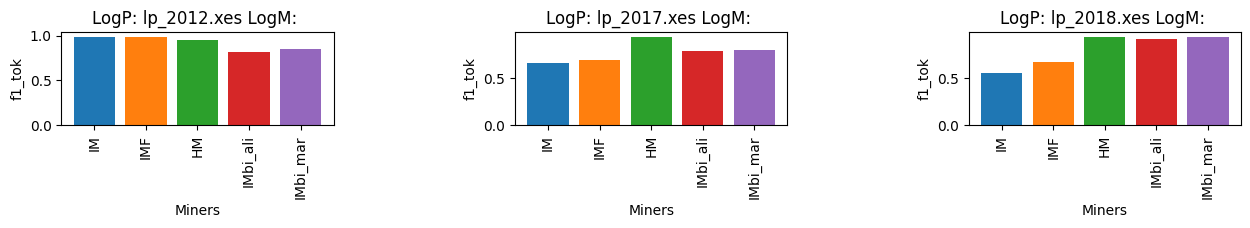

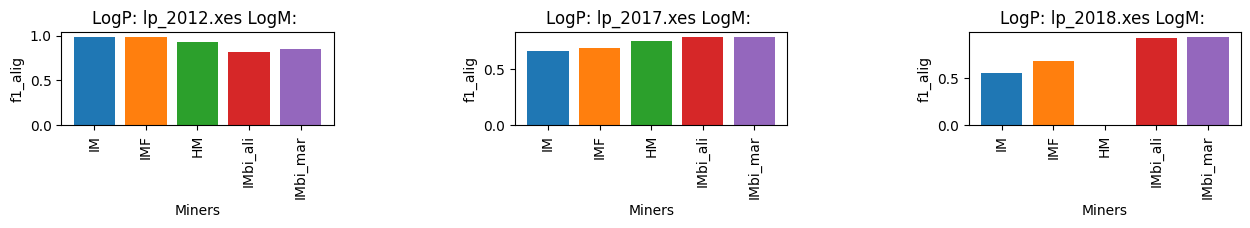

In [18]:
if runSingleLog == False:
  displayDoubleLog(df)
else:
  displaySingleLog(df)

Displaying: IM lp_2012.xes 


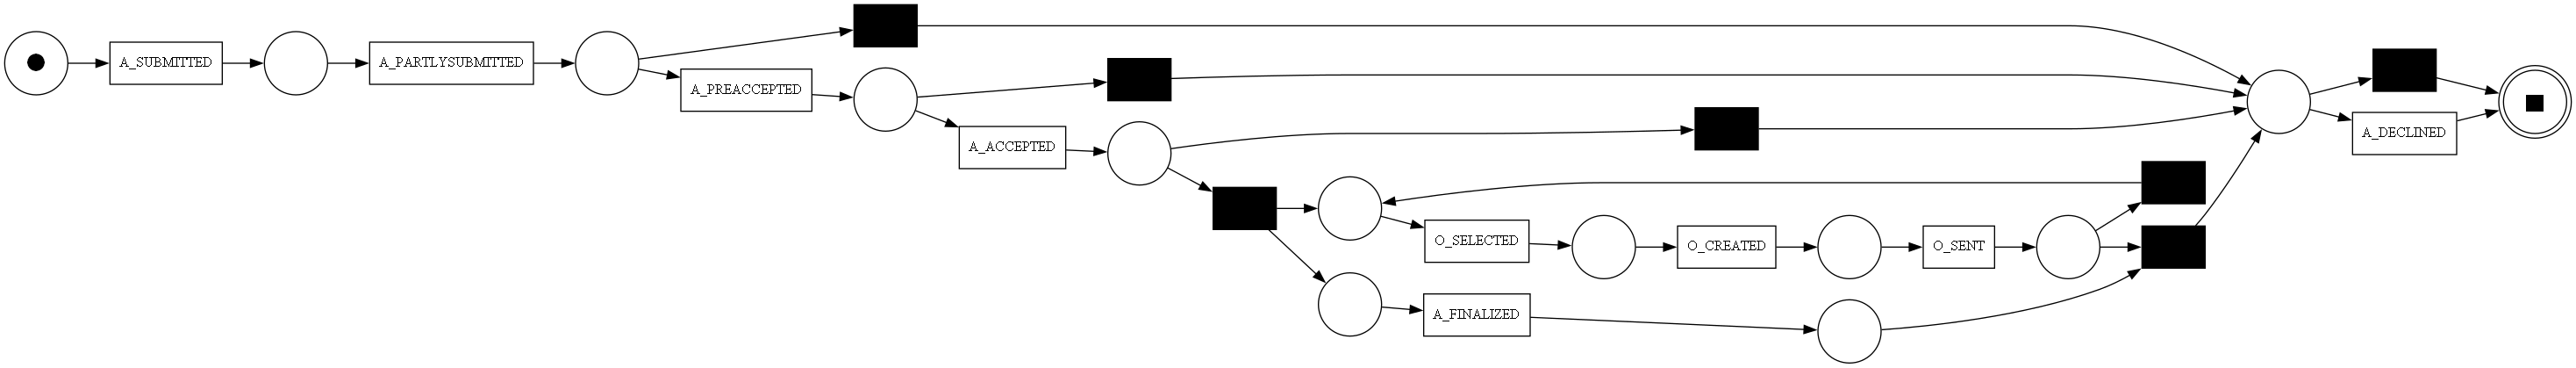

Displaying: IMbi_mar lp_2012.xes 


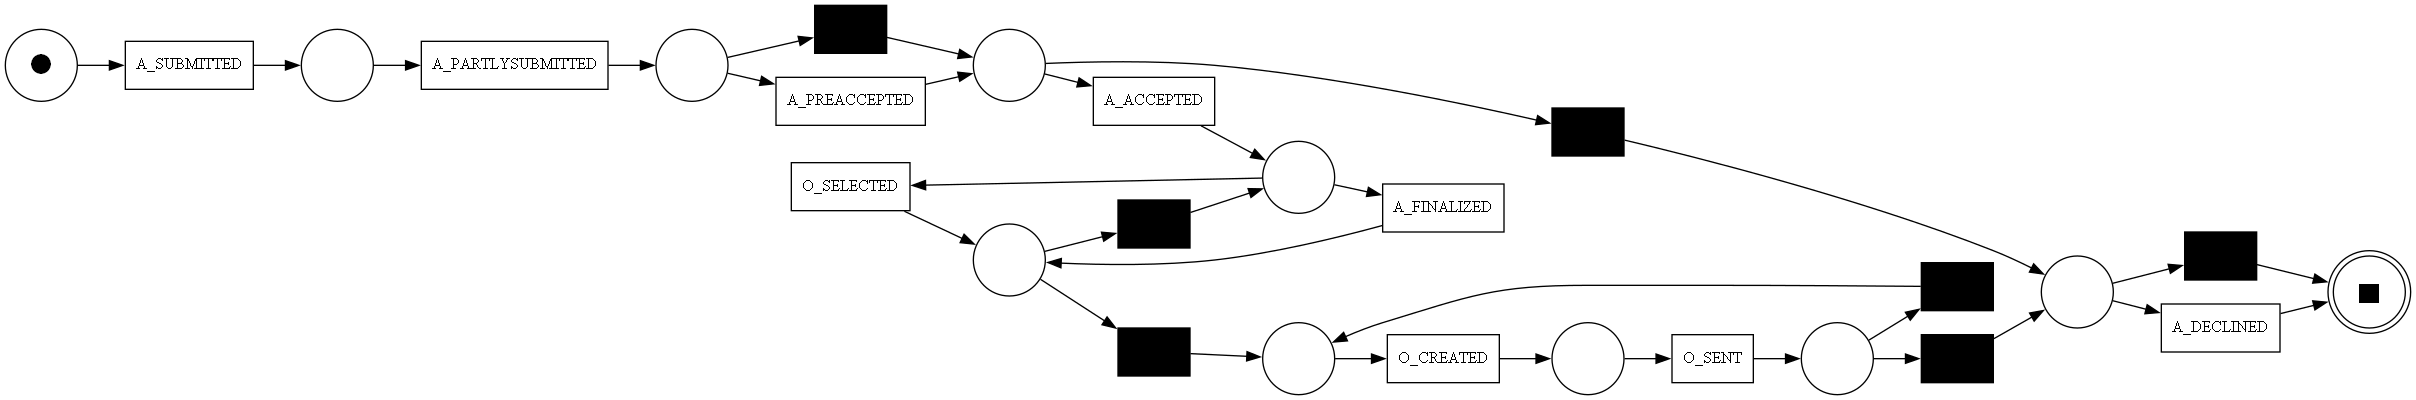

Displaying: IMbi_ali lp_2012.xes 


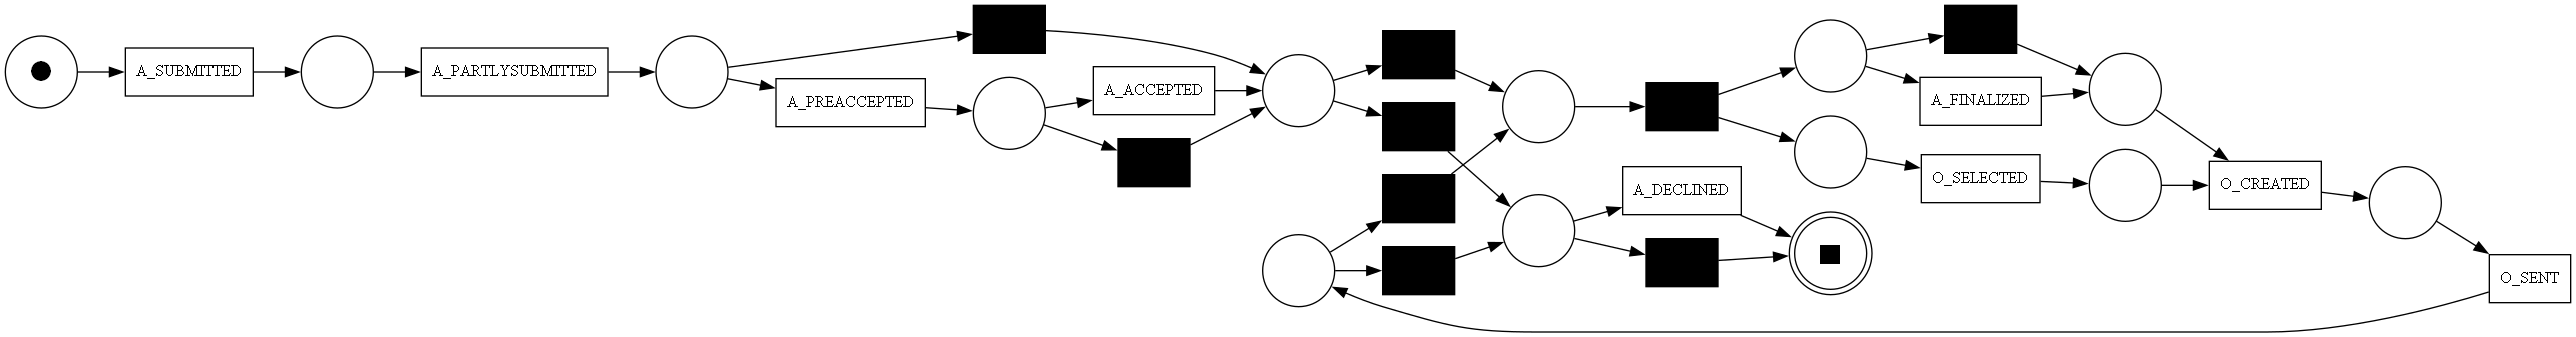

In [19]:
if runSingleLog == False:
  visualize_petriNet(df, "IM", "lp_2012.xes", "")
  visualize_petriNet(df, "IMbi_mar", "lp_2012", "lm_2012")
  visualize_petriNet(df, "IMbi_ali", "lp_2012", "lm_2012")
else:
  visualize_petriNet(df, "IM", "lp_2012.xes", "")
  visualize_petriNet(df, "IMbi_mar", "lp_2012.xes", "")
  visualize_petriNet(df, "IMbi_ali", "lp_2012.xes", "")


In [20]:
if False:
  display(df)

from pm4py.objects.petri_net.exporter import exporter as pnml_exporter

net, im, fm = df.iloc[4].net, df.iloc[4].im, df.iloc[4].fm
view_petri_net(net, im, fm)
pnml_exporter.apply(net, im, "petri_IMbi.pnml", final_marking=fm)